# Accessing the EDA from JupyterHub

The EDA is just a TimescaleDB database, which is just a PostgreSQL database with the TimescaleDB extension installed. The JupyterHub environment contains the psycopg PostgreSQL client library, and sqlalchemy to provide integration with pandas. The environment also sets the `PGHOST`, `PGDATABASE`, `PGUSER` and `PGPASSWORD` environment variables, so read-only access to the EDA is available without explicitly providing any credentials.

In [1]:
import os

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

print("\n".join(f"{k} = {v}" for k, v in os.environ.items() if k.startswith("PG")))

PGPLOT_DIR = /usr/lib/pgplot5
PGPLOT_FONT = /usr/lib/pgplot5/grfont.dat
PGPLOT_FOREGROUND = black
PGPASSWORD = a032hasdo@9DUFhs_asfaa55Z
PGPLOT_DEV = /xs
PGUSER = eda_ro
PGPLOT_INCLUDES = /usr/include
PGDATABASE = eda
PGPLOT_BACKGROUND = white
PGHOST = eda.ska-tango-archiver


## Using pandas.read_sql_query

This gets a SQL query result directly into a dataframe. The first argument is the SQL query, and the second is a DB connection string, which we can leave mostly empty thanks to those environment variables. The `params` argument contains parameters to be substituted into the SQL query, according to standard [psycopg conventions](https://www.psycopg.org/psycopg3/docs/basic/params.html).

In [7]:
df = pd.read_sql_query(
    """
    SELECT 1, 'hello', %s, %s, %s
    """,
    "postgresql+psycopg://",
    params=("a parameter", 42, ["A", "B", "C"]),
)
display(df)
display(df.dtypes)

?column? ?column?     ?column? ?column? ?column?
0        1    hello  a parameter       42  {A,B,C}

?column?     int64
?column?    object
?column?    object
?column?     int64
?column?    object
dtype: object

## EDA database schema basics

### The `att_conf` table

The `att_conf` table describes the set of all attributes that are archived. Each attribute of each device has a unique `att_conf_id` identifier, used as a foreign key in the tables which actually store the data. `cs_name`, `domain`, `family` and `member` identify the Tango device, while `name` is the name of the attribute.

In [8]:
pd.read_sql_query(
    "select * from att_conf order by random() limit 5",
    "postgresql+psycopg://",
)

att_conf_id                                           att_name  \
0         4791  tango://databaseds.ska-low.svc.mccs.low.intern...   
1         7436  tango://databaseds.ska-low.svc.mccs.low.intern...   
2          168  tango://databaseds.ska-low.svc.mccs.low.intern...   
3         6868  tango://databaseds.ska-low.svc.mccs.low.intern...   
4          796  tango://databaseds.ska-low.svc.mccs.low.intern...   

   att_conf_type_id  att_conf_format_id  att_conf_write_id  \
0                 3                   1                  1   
1                11                   2                  4   
2                 1                   2                  1   
3                14                   1                  1   
4                11                   1                  4   

             table_name                                            cs_name  \
0    att_scalar_devlong  databaseds.ska-low.svc.mccs.low.internal.skao....   
1   att_array_devlong64  databaseds.ska-low.svc.mccs.low.internal.skao....   
2  att_array_devboolean  databaseds.ska-low.svc.mccs.low.internal.skao....   
3    att_scalar_devenum  databaseds.ska-low.svc.mccs.low.internal.skao....   
4  att_scalar_devlong64  databaseds.ska-low.svc.mccs.low.internal.skao....   

     domain    family      member                      name  ttl   hide  
0  low-mccs      tile  s8-1-tpm16                  ppsdelay    0  False  
1  low-mccs  smartbox   s8-1-sb20  femcurrenttripthresholds    0  False  
2  low-mccs  smartbox  s10-3-sb21       portbreakerstripped    0  False  
3  low-mccs      beam     s8-6-03                  obsstate    0  False  
4  low-mccs  smartbox   s8-1-sb21  fem7currenttripthreshold    0  False

### The `att_<format>_<dtype>` tables
For each Tango data type and format (scalar, array or image), there is a table containing the actual archived attribute values. The table name is of the form `att_<format>_<dtype>`. The `table_name` column of the `att_conf` table indicates which value table is used for each attribute.

In [9]:
pd.read_sql_query(
    "select distinct table_name from att_conf order by table_name",
    "postgresql+psycopg://",
)

table_name
0    att_array_devboolean
1     att_array_devdouble
2       att_array_devenum
3     att_array_devlong64
4     att_array_devstring
5      att_image_devfloat
6   att_scalar_devboolean
7    att_scalar_devdouble
8      att_scalar_devenum
9      att_scalar_devlong
10   att_scalar_devlong64
11    att_scalar_devstate
12   att_scalar_devstring

## Making queries

Selecting values for a specific attribute is done by joining the `att_conf` table to the relevant `att_<format>_<dtype>` table using the `att_conf_id` column:

  ```
  select * from att_conf join att_scalar_devdouble on att_conf.att_conf_id = att_scalar_devdouble.att_conf_id ...
  ```
`att_conf_id` is the only column these tables have in common, so you can use a NATURAL JOIN for brevity:

  ```
  select * from att_conf natural join att_scalar_devdouble ...
  ```

Because this pattern is so common, we have created views for these JOINs for each data type, to simplify queries. These views are the same name as the attribute data tables, but with `att_` omitted:

  ```
  select * from scalar_devdouble ...
  ```

The following query will select the first 5 valid recorded values of type scalar_devdouble (`quality` here refers to Tango attribute quality - 0 is `VALID`):

In [10]:
pd.read_sql_query(
    "select * from scalar_devdouble where quality = 0 limit 5",
    "postgresql+psycopg://",
)

att_conf_id                        data_time  value_r value_w  quality  \
0         5262 2024-05-22 02:49:20.396192+00:00     0.91    None        0   
1         6077 2024-05-22 02:49:20.396378+00:00    23.51    None        0   
2         5304 2024-05-22 02:49:20.396466+00:00    23.56    None        0   
3         6601 2024-05-22 02:49:20.396553+00:00    23.71    None        0   
4         3559 2024-05-22 02:49:20.396635+00:00    28.24    None        0   

  att_error_desc_id details  \
0              None    None   
1              None    None   
2              None    None   
3              None    None   
4              None    None   

                                            att_name  att_conf_type_id  \
0  tango://databaseds.ska-low.svc.mccs.low.intern...                 5   
1  tango://databaseds.ska-low.svc.mccs.low.intern...                 5   
2  tango://databaseds.ska-low.svc.mccs.low.intern...                 5   
3  tango://databaseds.ska-low.svc.mccs.low.intern...                 5   
4  tango://databaseds.ska-low.svc.mccs.low.intern...                 5   

   att_conf_format_id  att_conf_write_id            table_name  \
0                   1                  1  att_scalar_devdouble   
1                   1                  1  att_scalar_devdouble   
2                   1                  1  att_scalar_devdouble   
3                   1                  1  att_scalar_devdouble   
4                   1                  1  att_scalar_devdouble   

                                             cs_name    domain family member  \
0  databaseds.ska-low.svc.mccs.low.internal.skao....  low-mccs   fndh   s8-1   
1  databaseds.ska-low.svc.mccs.low.internal.skao....  low-mccs   fndh   s8-1   
2  databaseds.ska-low.svc.mccs.low.internal.skao....  low-mccs   fndh   s8-1   
3  databaseds.ska-low.svc.mccs.low.internal.skao....  low-mccs   fndh   s8-1   
4  databaseds.ska-low.svc.mccs.low.internal.skao....  low-mccs   fndh   s8-1   

                      name  ttl   hide  
0            psu48vcurrent    0  False  
1         paneltemperature    0  False  
2          fncbtemperature    0  False  
3  commsgatewaytemperature    0  False  
4   powermoduletemperature    0  False

### Example: querying smartbox temperatures

Realistically, you likely want to select attributes for a particular time window and device or set of devices. Trim down what you select using the WHERE clause. This example queries PCB temperatures for the last hour for all smartboxes on station S8-6.

Things to note about this query:
* we're only looking at values whose `data_time` is greater than now minus one hour.
* it uses the `time_bucket` function to average values over a one-minute time window, which requires the use of a `group by` clause.
* it uses the `member` column to identify each device ("member" is the last segment of a Tango device name)

In [12]:
pcb_temps = pd.read_sql_query(
    """
    select
      time_bucket('1 minute', data_time) time,
      member device,
      avg(value_r) temp
    from
      scalar_devdouble
    where
      data_time > NOW() - '1 hour'::interval
      and family = 'smartbox'
      and member like 's8-1-%%'
      and name = 'pcbtemperature'
    group by
      1, 2
    """,
    "postgresql+psycopg://",
)
pcb_temps

time     device       temp
0    2024-10-07 07:31:00+00:00  s8-1-sb01  61.490000
1    2024-10-07 07:31:00+00:00  s8-1-sb02  61.560000
2    2024-10-07 07:31:00+00:00  s8-1-sb03  64.040000
3    2024-10-07 07:31:00+00:00  s8-1-sb04  64.760000
4    2024-10-07 07:31:00+00:00  s8-1-sb05  62.210000
...                        ...        ...        ...
1459 2024-10-07 08:31:00+00:00  s8-1-sb20  60.550000
1460 2024-10-07 08:31:00+00:00  s8-1-sb21  62.856667
1461 2024-10-07 08:31:00+00:00  s8-1-sb22  62.310000
1462 2024-10-07 08:31:00+00:00  s8-1-sb23  55.130000
1463 2024-10-07 08:31:00+00:00  s8-1-sb24  63.270000

[1464 rows x 3 columns]

This gives us time series data, where each row represents a specific device for a specific time period. We can use the pandas `pivot()` function to reshape this data:

In [7]:
pcb_temps_by_smartbox = pcb_temps.pivot(index="time", columns="device")
pcb_temps_by_smartbox

temp                                          \
device                    s8-1-sb01 s8-1-sb02 s8-1-sb03 s8-1-sb04 s8-1-sb05   
time                                                                          
2024-09-20 03:50:00+00:00   58.1900   59.1600   59.0000   61.2700   58.6300   
2024-09-20 03:51:00+00:00   58.1900   59.1600   59.0200   61.2325   58.6300   
2024-09-20 03:52:00+00:00   58.1900   59.1600   59.0275   61.2075   58.6300   
2024-09-20 03:53:00+00:00   58.2050   59.1675   59.0575   61.1700   58.6450   
2024-09-20 03:54:00+00:00   58.2200   59.1825   59.0725   61.1400   58.6600   
...                             ...       ...       ...       ...       ...   
2024-09-20 04:46:00+00:00   58.6825   59.5150   60.3600   61.7225   58.3750   
2024-09-20 04:47:00+00:00   58.6975   59.5300   60.3600   61.7750   58.4100   
2024-09-20 04:48:00+00:00   58.7275   59.5450   60.3750   61.7975   58.4325   
2024-09-20 04:49:00+00:00   58.7425   59.5500   60.3900   61.8425   58.4550   
2024-09-20 04:50:00+00:00   58.7500   59.5500   60.4200   61.8900   58.4700   

                                                                             \
device                    s8-1-sb06 s8-1-sb07 s8-1-sb08 s8-1-sb09 s8-1-sb10   
time                                                                          
2024-09-20 03:50:00+00:00   58.6900   57.9900   50.3000   58.8000   58.3000   
2024-09-20 03:51:00+00:00   58.6975   57.9900   50.3150   58.8300   58.3000   
2024-09-20 03:52:00+00:00   58.7275   57.9900   50.3300   58.8300   58.3300   
2024-09-20 03:53:00+00:00   58.7550   58.0125   50.3450   58.8525   58.3375   
2024-09-20 03:54:00+00:00   58.7700   58.0350   50.3725   58.8750   58.3600   
...                             ...       ...       ...       ...       ...   
2024-09-20 04:46:00+00:00   59.8900   58.9700   51.2800   59.9400   59.5875   
2024-09-20 04:47:00+00:00   59.9050   58.9925   51.2950   59.9700   59.6175   
2024-09-20 04:48:00+00:00   59.9200   59.0000   51.3200   60.0075   59.6625   
2024-09-20 04:49:00+00:00   59.9400   59.0100   51.3300   60.0300   59.6750   
2024-09-20 04:50:00+00:00   59.9700   59.0275   51.3525   60.0525   59.6900   

                           ...                                           \
device                     ...  s8-1-sb15 s8-1-sb16 s8-1-sb17 s8-1-sb18   
time                       ...                                            
2024-09-20 03:50:00+00:00  ...  56.430000   59.8900   56.0400   57.1600   
2024-09-20 03:51:00+00:00  ...  56.445000   59.8900   56.0400   57.1750   
2024-09-20 03:52:00+00:00  ...  56.475000   59.9125   56.0400   57.2100   
2024-09-20 03:53:00+00:00  ...  56.505000   59.9300   56.0400   57.2100   
2024-09-20 03:54:00+00:00  ...  56.525000   59.9625   56.0700   57.2325   
...                        ...        ...       ...       ...       ...   
2024-09-20 04:46:00+00:00  ...  57.747500   60.6925   56.8350   58.0500   
2024-09-20 04:47:00+00:00  ...  57.770000   60.7300   56.8725   58.0950   
2024-09-20 04:48:00+00:00  ...  57.800000   60.7450   56.8850   58.1000   
2024-09-20 04:49:00+00:00  ...  57.830000   60.7500   56.9000   58.1375   
2024-09-20 04:50:00+00:00  ...  57.836667   60.7600   56.9300   58.1500   

                                                                             \
device                    s8-1-sb19 s8-1-sb20 s8-1-sb21 s8-1-sb22 s8-1-sb23   
time                                                                          
2024-09-20 03:50:00+00:00   58.3800   56.8800   61.7900   62.1500   52.1800   
2024-09-20 03:51:00+00:00   58.4025   56.8800   61.8125   62.1500   52.1750   
2024-09-20 03:52:00+00:00   58.4400   56.8800   61.8200   62.1425   52.2150   
2024-09-20 03:53:00+00:00   58.4750   56.8800   61.8275   62.1425   52.2375   
2024-09-20 03:54:00+00:00   58.4925   56.8950   61.8275   62.1500   52.2700   
...                             ...       ...       ...       ...       ...   
2024-09-20 04:46:00+00:00   59.5300   57.6525   62.1425

With this data this format, we can plot it easily:

<Axes: xlabel='time'>

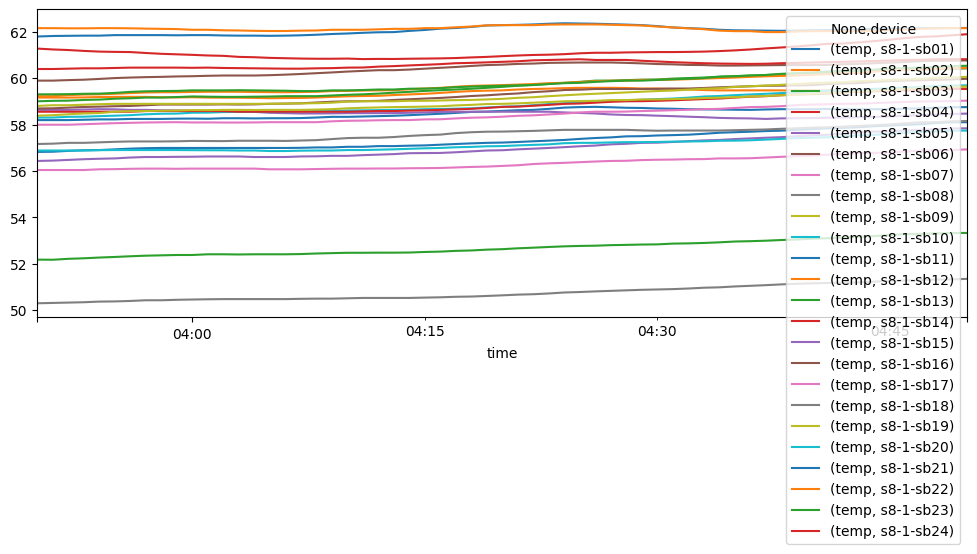

In [8]:
pcb_temps_by_smartbox.plot(figsize=(12, 4))

### Example: plotting integrated bandpasses

This example selects the most recent bandpass sample for each polarisation for station S9-2, averages across antennas and plots each polarisation:

In [9]:
bandpasses = pd.read_sql_query(
    """
    select distinct on (att_conf_id) att_conf_id, data_time, name, value_r
    from image_devfloat
    where family = 'daqreceiver' and member = 's9-2-bandpass'
    order by 1, 2 desc
    """,
    "postgresql+psycopg://",
)

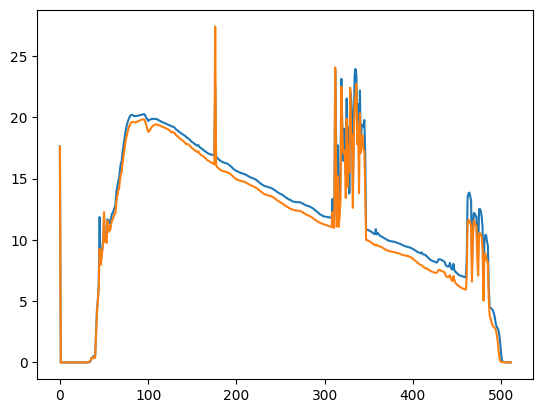

In [10]:
plt.plot(np.mean(np.stack(bandpasses.value_r).transpose(), axis=1))
plt.show()

### Example: fetching PPS delay statistics over a period of time

In [ ]:
import re

def interpolate(query: str):
    return query.replace("$__interval", "15s")

    # https://github.com/grafana/grafana/blob/0401fa165290b9e9589ec2e46024362a0e1ee508/pkg/tsdb/grafana-postgresql-datasource/sqleng/sql_engine.go#L374
	# sql = strings.ReplaceAll(sql, "$__interval_ms", strconv.FormatInt(interval.Milliseconds(), 10))
	# sql = strings.ReplaceAll(sql, "$__interval", gtime.FormatInterval(interval))
	# sql = strings.ReplaceAll(sql, "$__unixEpochFrom()", fmt.Sprintf("%d", timeRange.From.UTC().Unix()))
	# sql = strings.ReplaceAll(sql, "$__unixEpochTo()", fmt.Sprintf("%d", timeRange.To.UTC().Unix()))

def render_macro(macro, *args) -> str:
    print(macro, args)
    interval, *args = map(interpolate, args)
    if macro == "__timeGroup":
        return "time_bucket('%.3fs',%s)" % pd.Timedelta(interval).to_pytimedelta().total_seconds(), args[0]
    return f"$_$_{macro}({','.join(args)


def from_grafana(query):
    query = interpolate(query)
    sexpr = r"\$([_a-zA-Z0-9]+)\(([^\)]*)\)"
    return re.sub(sexpr, lambda m: render_macro(*m.groups()), query)

# const rsIdentifier = `([_a-zA-Z0-9]+)`
# const sExpr = `\$` + rsIdentifier + `\(([^\)]*)\)`

from_grafana(

    """
    SELECT
      $__timeGroup(data_time, $__interval, NULL),
      member metric,
      avg(value_r) ppsDelay
    FROM
      scalar_devlong
    WHERE
      $__timeFilter(data_time)
      AND name = 'ppsdelay'
      AND member in ($tpm)
    GROUP BY 1, 2
    ORDER BY 1
    """
)